In [210]:
import numpy as np
import math

In [234]:

class activation_function:
    def pass_values(self,input_values):
        pass
    def get_gradient(self,gradient):
        pass


class layer:
    def forward(self,input_values):
        pass
    def get_running_gradient(self,gradient):
        pass
    def get_parameter_gradients(self,gradient,X):
        pass
    def get_parameters(self):
        pass


class optimizer:
    def update_parameter(self,parameter):
        pass

class cost_function:
    def get_cost(self,output_values, expected_values):
        pass
    def get_gradient(self,output_values, expected_values):
        pass

In [235]:
class relu(activation_function):
    def pass_value(self,input_values):
        self.input_values=input_values
        return np.maximum(input_values,0)
    def get_gradient(self):
        return (self.input_values > 0).astype(float)


class sigmoid(activation_function):
    def pass_value(self,input_values):
        self.output=1 / (1 + np.exp(-input_values))
        return self.output
    def get_gradient(self):
        return self.output * (1- self.output)





In [236]:
class SGD(optimizer):
    def __init__(self,alpha):
        self.alpha=alpha
    def update_parameter(self,gradient,parameters):
        if not parameters:
            return

        for index in range(len(parameters)):
            parameters[index][:]-= gradient[index] * self.alpha


In [237]:
class MSE(cost_function):
    def get_cost(self,output_values, expected_values):
        return 0.5*np.mean(np.square(expected_values-output_values))
    def get_gradient(self,output_values, expected_values):
        return   0.5*(-expected_values+output_values)

class binary_cross_entropy(cost_function):
    def get_cost(self,output_values, expected_values):
        output_values=np.clip(output_values,1e-15,1-1e-15)
        loss=-(expected_values* np.log(output_values)+(1-expected_values)*np.log(1-output_values))
        return np.mean(loss)
    def get_gradient(self,output_values, expected_values):
        output_values=np.clip(output_values,1e-15,1-1e-15)
        return  -(expected_values/output_values) + ((1-expected_values)/(1-output_values))



In [238]:


def get_activation_functions():
    return {
        "relu":relu(),
  #      "leaky_relu":leaky_relu,
        "sigmoid":sigmoid(),
  #      "tanh":tanh,
    }

def get_cost_functions():
    return {
        "MSE":MSE(),
        "binary_cross_entropy":binary_cross_entropy()

    }

def get_optimizers():
    return {
        "SGD":SGD,
    }



In [239]:
def initialize_weights(shape, activation_function):
    if len(shape)>2:
        fan_in = shape[0]*shape[1] * shape[3]
        fan_out = shape[0]*shape[2] * shape[3] 

    else:
        fan_in=shape[0]
        fan_out=shape[1]

    match activation_function:
        case "sigmoid" | "tanh":
            weights = np.sqrt(2 / (fan_in + fan_out)) *np.random.randn(*shape)
        case "relu" | "leaky_relu":
            limit = np.sqrt(6 / fan_in)
            weights = np.random.uniform(-limit,limit, shape)

    return weights



In [240]:
class linear(layer):
    def __init__(self,input_size,output_size,activation_function):
        self.activation_function=get_activation_functions()[activation_function.lower()]
        self.weights=initialize_weights((input_size,output_size),activation_function.lower())
        self.bias=np.zeros(output_size)

    def forward(self,input_values):
        return self.activation_function.pass_value(input_values @ self.weights + self.bias)

    def get_running_gradient(self,gradient):
        gradient=gradient * self.activation_function.get_gradient()
        self.dX=gradient @ self.weights.T
        return self.dX

    def get_parameter_gradients(self,gradient, X):
        self.dW= X.shape[0]**(-1) *(  X.T @ gradient )
        self.db= ( gradient.mean(axis=0))
        return [self.dW,self.db]

    def get_parameters(self):
        return [self.weights,self.bias]


In [241]:


def conv_pad_kernels(kernels,feature_map):
    pad_dim_kernel=((feature_map.shape[0]-1,0),
                    (feature_map.shape[1]-1,0), 
                    ( 0,0 ),( 0,0 ))



    padded_kernel = np.pad(kernels, pad_width= pad_dim_kernel,
                           mode='constant', constant_values=0)
    return padded_kernel

def conv_pad_feature_map(kernels,feature_map):
    pad_dim_kernel=((kernels.shape[0]-1,0),
                    (kernels.shape[1]-1,0), 
                    ( 0,0 ))

                    


    padded_feature_map = np.pad(feature_map, pad_width= pad_dim_kernel,
                           mode='constant', constant_values=0)
    return padded_feature_map


def valid_convolution_cnn2d(kernels,feature_map,stride,padding=False):
    
    padded_kernels=conv_pad_kernels(kernels,feature_map)
    padded_feature_map=conv_pad_feature_map(kernels,feature_map)
    
    padded_kernels = np.fft.ifftshift(padded_kernels,axes=(0,1))
    padded_feature_map = np.fft.ifftshift(padded_feature_map, axes=(0,1))


    transformed_kernels=np.fft.fft2(padded_kernels, axes=(0,1))
    transformed_feature_map=np.fft.fft2(padded_feature_map, axes=(0,1))

    transformed_feature_map= transformed_feature_map[...,np.newaxis]
    product_result=transformed_kernels*transformed_feature_map
    result = np.sum(product_result, axis=2)
    output=np.fft.ifft2(result, axes=(0,1)).real

    if not padding:

        crop=kernels.shape[0] - 1
        output=output[crop:-crop,crop:-crop,:]

    output=output[::stride,::stride,:]

    return output


In [242]:

class convolutional_2d(layer):
    def __init__(self,input_channel_size, output_channel_size, kernel_size, padding, stride, activation_function):
        self.activation_function=get_activation_functions()[activation_function.lower()]
        self.kernels=initialize_weights((kernel_size,kernel_size,input_channel_size,
                                         output_channel_size),activation_function.lower())
        self.bias=np.zeros(output_channel_size)
        self.padding=padding
        self.stride=stride
    def forward(self,input_values):
        convolution_result=valid_convolution_cnn2d(self.kernels,input_values,self.stride,self.padding)
        result_bias=convolution_result + self.bias
        return self.activation_function.pass_value(result_bias)

    def get_running_gradient(self,gradient):
        gradient=gradient*self.activation_function.get_gradient()
        dX= valid_convolution_cnn2d(gradient,self.kernels[::-1,::-1,:],self.stride,self.padding)
        return dX

    def get_parameter_gradients(self,gradient, X):

        if self.padding:
            X_modified= conv_pad_feature_map(X,self.kernels)
        else:
            X_modified=X

        self.dK= valid_convolution_cnn2d(gradient, X_modified,self.stride ,False)
        self.db= np.sum(gradient, axis=(0,2,3))/ gradient.shape[0]
        return [self.dK,self.db]

    def get_parameters():
        return [self.kernels,self.bias]


class convolutional_3d(layer):
    def __init__(kernel_dimensions, stride, bias, activation_function):
        pass

class flatten(layer):
    def forward(self,X):
        self.shape=X.shape
        return X.reshape(X.shape[0], -1)

    def get_running_gradient(self,gradient):
        return gradient.reshape(self.shape)

    def get_parameters():
        return []
    def get_parameter_gradients():
        return []


class max_pool(layer):
    def __init__(self):
        pass

    def get_parameters():
        return []
    def get_parameter_gradients():
        return []


class avg_pool2d(layer):
    def __init__(self):
        pass

    def get_parameters():
        return []
    def get_parameter_gradients():
        return []


class max_pool2d(layer):
    def __init__(self):
        pass

    def get_parameters():
        return []
    def get_parameter_gradients():
        return []

class avg_pool3d(layer):
    def __init__(self):
        pass

    def get_parameters():
        return []
    def get_parameter_gradients():
        return []

class max_pool3d(layer):
    def __init__(self):
        pass

    def get_parameters():
        return []
    def get_parameter_gradients():
        return []


In [243]:
class model():
    def __init__(self,layers,cost_function,optimizer, batch_size, X, Y,epochs):
        self.layers=layers
        self.optimizer=optimizer
        self.epochs=epochs
        self.layer_values=[]

        self.cost_function=get_cost_functions()[cost_function]
        self.Y=Y
        self.X=X
        self.number_of_batches= X.shape[0] // batch_size
        self.batch_size=batch_size
        self.running_avg=self.batch_size*(-1)
        self.costs=0

    def train(self):
        for epoch in range(self.epochs):
            for batch in range(self.number_of_batches):
                self.layer_values=[]
                start=batch*self.batch_size
                end=min(batch*self.batch_size+self.batch_size, self.X.shape[0])
                batch_range= slice(start,end)
                self.forward(batch_range)
                self.backward(batch_range)

    def save(self):
        pass


    def pass_inputs(self,values,labels):
        self.layer_values = []

        self.layer_values.append(values)

        for layer_number, layer in enumerate(self.layers):
            self.layer_values.append(layer.forward(self.layer_values[layer_number]))

        return self.cost_function.get_cost(output_values=self.layer_values[-1],
                                           expected_values=labels.reshape(self.layer_values[-1].shape))


    def forward(self,batch_range):
        self.layer_values.append(self.X[batch_range])

        for layer_number, layer in enumerate(self.layers):
            self.layer_values.append(layer.forward(self.layer_values[layer_number]))

        labels= self.Y[batch_range].reshape(self.layer_values[-1].shape)
        self.costs= self.cost_function.get_cost(output_values=self.layer_values[-1], expected_values=labels)



    def backward(self, batch_range):

        labels= self.Y[batch_range].reshape(self.layer_values[-1].shape)

        running_gradient=self.cost_function.get_gradient(self.layer_values[-1], labels)

        for layer_number in range(-1,-len(self.layers)-1,-1):

            parameter_update_gradient = self.layers[layer_number].get_parameter_gradients(
                running_gradient, self.layer_values[layer_number-1])

            running_gradient= self.layers[layer_number].get_running_gradient(running_gradient)

            self.optimizer.update_parameter(parameter_update_gradient,
                                            self.layers[layer_number].get_parameters())







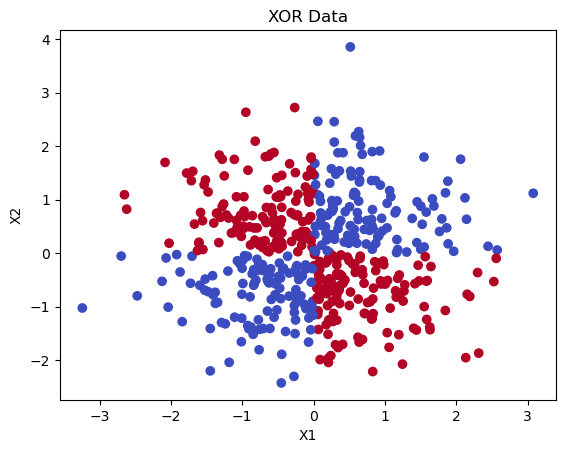

In [244]:
import matplotlib.pyplot as plt

np.random.seed(42)
X = np.random.randn(500, 2)

Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)

plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='coolwarm')
plt.title("XOR Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


In [245]:


trainable_model = model([
    linear(2, 32, "relu"),
    linear(32, 32, "relu"),
    linear(32, 1, "sigmoid")

], "binary_cross_entropy", SGD(0.001), 100, X[:500,:], Y[:500], 10000)


In [246]:


trainable_model_2 = model([
    linear(2, 2, "relu"),
    linear(2, 1, "sigmoid"),

    ], "MSE", SGD(0.01), 10, X[:90,:], np.random.randn(90), 10)


In [247]:
trainable_model.train()
trainable_model.costs


np.float64(4.246680747559763e-05)

In [248]:
trainable_model.pass_inputs(X[91:,:],Y[91:])

np.float64(0.0003928337069038905)

In [249]:
trainable_model_2.pass_inputs(X[91:,:],Y[91:])

np.float64(0.15293626194799795)

In [261]:
kernels=np.random.randn(5,5,3,1)
features=np.random.randn(12,12,3)

from matplotlib.pyplot import imshow

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.785405872725681..2.722948687724303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2160571992571363..3.276399345113].


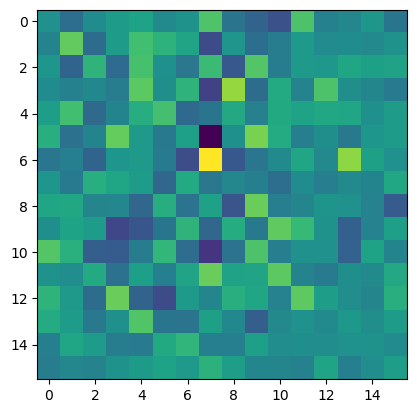

In [262]:
result=valid_convolution_cnn2d(kernels,features,1,padding=True)

imshow(kernels[:,:,:,0])
imshow(features)
imshow(result)


In [263]:
obj=convolutional_2d(3, 3, 3, False, 1,"relu")
obj.forward(features).shape


(10, 10, 3)

In [264]:

trainable_model = model([
    convolutional_2d(3,3,5,False,1,"relu"),
    convolutional_2d(3,3,3,False,1,"relu"),
    flatten(),
    linear(3*6**2, 32, "relu"),
    linear(32, 32, "relu"),
    linear(32, 1, "sigmoid")

], "binary_cross_entropy", SGD(0.001), 100, X[:500,:], Y[:500], 10000)
